In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
# config device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a directory doesn't already exist
sample_dir = 'vae_samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
# define hyper-parameters (5 points)
image_size = 28*28
h_dim = 512
z_dim = 256
num_epochs = 20
batch_size = 64
learning_rate = 0.001

In [4]:
# download MNIST dataset
dataset = torchvision.datasets.MNIST(root='./data/',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
# define your VAE Model (10 points)
class VAE(nn.Module):
  def __init__(self, image_size =784, h_dim = 500, z_dim = 100):
    super(VAE, self).__init__()
    
    # 1. Define the model achitecture
    # fc1 : input layer -> hidden layer
    self.fc1 = nn.Linear(image_size, h_dim) 
    
    # fc2: encoder layer -> feature layer 1: return mu
    self.fc2 = nn.Linear(h_dim, z_dim)  
    
    # fc3: encoder layer -> feature layer 2: return log_var
    self.fc3 = nn.Linear(h_dim, z_dim) 
    
    # fc4: decoder layer
    self.fc4 = nn.Linear(z_dim, h_dim)
    
    # fc5: decoder layer -> output layer
    self.fc5 = nn.Linear(h_dim, image_size)
  
  def encode(self, x):
    # 2. define the encoding method to encode input features to hidden representations and get the encoded feature represenataion distribution variables
    hidden = F.relu(self.fc1(x))
    mu = self.fc2(hidden)
    log_var = self.fc3(hidden)
    return mu, log_var
  
  def reparameterize(self, mu, log_var):
    # 3. reparameterize the distribution of encoded features representations (mu, and log_var) for decoding purpose
    std = torch.exp(log_var*0.5)
    eps = torch.randn_like(std)
    return mu + std*eps
  
  def decode(self, z):
    # 4. define the decoding method to decode input features to hidden representations that will be reconstructed
    hidden = F.relu(self.fc4(z))
    return torch.sigmoid(self.fc5(hidden))
  
  def forward(self, x):
    # 5. define the forward function for training VAE
    # Procedure: 
    #1. encode feature x
    #2. get input feature distribution mu and log_var of encoded feature representations by using the reparameterize method
    #3. reconstruct features based on the reparameterized features using decode method.

    mu, log_var = self.encode(x)
    z = self.reparameterize(mu, log_var)
    x_reconst = self.decode(z)
    return x_reconst, mu, log_var
  
model = VAE(h_dim=h_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Print your model architecture and check whether your model architecture is correct (1 point)
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=784, bias=True)
)


In [10]:
# Start VAE training and print out the training evaluation result (reconstruct loss and KL divergence) per epoch (2 points)
n = len(data_loader.dataset)
model.train()
for epoch in range(num_epochs):
  total_loss = 0
  total_kl = 0
  for i, (x, _) in enumerate(data_loader):
    x = x.to(device).view(-1, image_size)
    x_reconst, mu, log_var = model(x)

    # 1. define the reconstruction loss
    reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
    total_loss += reconst_loss.item()
    # 2. define the kl divergence: how similiar the prior distribution is comparing with the posterior dis
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_kl += kl_div.item()
    
    loss = reconst_loss + kl_div
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(epoch)
  print('Epoch: %d,    Recons loss: %.4f,   KLdiv: %.4f,   Loss: %.4f' %(epoch+1, total_loss / n, total_kl / n, (total_loss + total_kl) / n))

0
Epoch: 1,    Recons loss: 78.9431,   KLdiv: 25.7791,   Loss: 104.7222
1
Epoch: 2,    Recons loss: 78.8312,   KLdiv: 25.7714,   Loss: 104.6025
2
Epoch: 3,    Recons loss: 78.7109,   KLdiv: 25.7395,   Loss: 104.4504
3
Epoch: 4,    Recons loss: 78.5963,   KLdiv: 25.7496,   Loss: 104.3459
4
Epoch: 5,    Recons loss: 78.4977,   KLdiv: 25.7613,   Loss: 104.2590
5
Epoch: 6,    Recons loss: 78.4303,   KLdiv: 25.7902,   Loss: 104.2205
6
Epoch: 7,    Recons loss: 78.3004,   KLdiv: 25.7660,   Loss: 104.0664
7
Epoch: 8,    Recons loss: 78.2637,   KLdiv: 25.7819,   Loss: 104.0456
8
Epoch: 9,    Recons loss: 78.1915,   KLdiv: 25.7547,   Loss: 103.9462
9
Epoch: 10,    Recons loss: 78.0766,   KLdiv: 25.7498,   Loss: 103.8264
10
Epoch: 11,    Recons loss: 78.0409,   KLdiv: 25.7401,   Loss: 103.7809
11
Epoch: 12,    Recons loss: 78.0158,   KLdiv: 25.7305,   Loss: 103.7462
12
Epoch: 13,    Recons loss: 77.9093,   KLdiv: 25.7378,   Loss: 103.6471
13
Epoch: 14,    Recons loss: 77.8691,   KLdiv: 25.7506, 

In [11]:
# 1. Test the VAE model by saving the sampled image using the sample_image function in torchvision.util
# 2. and the reconstructed image from your model to the pre-defined 'samples' directory (2 points)
model.eval()
with torch.no_grad():
  # 1. Save the sampled images 
  z = torch.randn(batch_size, z_dim).to(device)
  # 2. get the decoded feature on z using model.decode method.
  # Remember, it's important for you to transform the decoded feature to the image dimenonailty torch.view()
  out = model.decode(z).view(-1, 1, 28, 28)
  save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

  # Save the reconstructed images
  out, _, _ = model(x)
  x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
  save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

Sampled images:


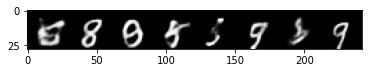

Reconstructed images:


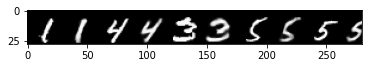

In [12]:
# Visualize first 5 image from the saved sampled images and reconstructed images
# and compare them to see whether they are similar (5 points)
from matplotlib import image
sampled = image.imread(os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))
reconst = image.imread(os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))
print('Sampled images:')
plt.imshow(sampled[:28,:280])
plt.show()
print('Reconstructed images:')
plt.imshow(reconst[:28,:280])
plt.show()